In [61]:
import os, sys
from os.path import expanduser
from collections import defaultdict
import numpy as np
from scipy import spatial
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython3/lib/python' % user_home
model_home = '%s/src/model' % user_home
dentate_home = '%s/dentate' % model_home
datasets_home = '/media/igr/d865f900-7fcd-45c7-a7a7-bd2a7391bc40/Data/DG/'
results_prefix = os.getenv('DG_RESULTS_DIR', '%s/results' % datasets_home)
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import neuroh5
from neuroh5.io import read_population_ranges, read_population_names, read_cell_attributes
import dentate
from dentate import utils, plot, stimulus, spikedata
from dentate.env import Env
from dentate.utils import Struct, zip_longest

In [62]:
def pf_dist(reference, result):
    dists = []
    for i in range(result.shape[0]):
        dists_i = []
        for j in range(reference.shape[0]):
            dist = np.linalg.norm(result[i, :] - reference[j, :])
            dists_i.append(dist)
        dists.append(np.min(np.asarray(dists_i)))
    return np.mean(dists)
        
    

In [63]:
bin_size = 5.
config_path = '%s/config/Full_Scale_Basis.yaml' % dentate_home
template_path = '%s/templates' % dentate_home
                          
rel_input_features_path = 'Full_Scale_Control/DG_input_features_20191119_compressed.h5'
input_features_path = '%s/%s' % (datasets_home, rel_input_features_path)
input_features_namespace_id = 'Place Selectivity A'

arena_id = 'A'
trajectory_id = 'Diag'

trajectory_path = '%s/Full_Scale_Control/DG_remap_spike_trains_20191113_compressed.h5' % datasets_home

In [64]:
baks_config = Struct(**{'BAKS Alpha': 4.77,'BAKS Beta': None})
pf_config = Struct(**{'Minimum Width': 15., 'Minimum Rate': 1.0})

env = None
if config_path is not None:
    env = Env(config_file=config_path, template_paths=template_path)
    if env.analysis_config is not None:
        baks_config.update(env.analysis_config['Firing Rate Inference'])
        pf_config.update(env.analysis_config['Place Fields'])



In [65]:
trj_x, trj_y, trj_d, trj_t = stimulus.read_trajectory(trajectory_path, arena_id, trajectory_id)
trajectory_si = spatial.cKDTree(np.column_stack((trj_x, trj_y)))


In [66]:
population = 'GC'
## Identify in-field and out-of-field cells relative to the trajectory of interest
input_features = defaultdict(lambda: dict())
in_field = defaultdict(set)
out_field = defaultdict(set)
query_radius = 1.
for population in [population]:
    this_in_field = in_field[population]
    this_out_field = out_field[population]
    it = read_cell_attributes(input_features_path, population, namespace=input_features_namespace_id)
    for itercount, (key, item) in enumerate(it):
        input_features[population][key] = item
        x_offsets = item['X Offset']
        y_offsets = item['Y Offset']
        widths = item['Field Width']
        for i in range(len(x_offsets)):
            x = x_offsets[i]
            y = y_offsets[i]
            w = widths[i]
            q = trajectory_si.query_ball_point([x, y], r=1.01 * (w / 2.))
            
            if len(q) > 0:
                #if itercount == 0:
                #    print('%f %f (%f): ' % (x, y, w), [np.linalg.norm(np.asarray([x,y]) - trajectory_si.data[ind]) for ind in q])
                input_features[population][key]['X Offset'] = np.asarray([x], dtype=np.float32)
                input_features[population][key]['Y Offset'] = np.asarray([y], dtype=np.float32)
                input_features[population][key]['Field Width'] = np.asarray([w], dtype=np.float32)
                this_in_field.add(key)
                if key in this_out_field:
                    this_out_field.remove(key)
                break
            else:
                this_out_field.add(key)
                

In [67]:
print(len(in_field['GC']))
print(len(out_field['GC']))

107431
89470


In [68]:

population = 'GC'

plot_sample_size = 50

in_field_subset = np.random.choice(np.asarray(list(in_field[population])), plot_sample_size)
out_field_subset = np.random.choice(np.asarray(list(out_field[population])), plot_sample_size)

in_field_subset_xs = []
in_field_subset_ys = []
in_field_subset_ws = []
for key in in_field_subset:
    item = input_features[population][key]
    x_offsets = item['X Offset']
    y_offsets = item['Y Offset']
    widths = item['Field Width']
    for i in range(len(x_offsets)):
        x = x_offsets[i]
        y = y_offsets[i]
        w = widths[i]
        in_field_subset_xs.append(x)
        in_field_subset_ys.append(y)
        in_field_subset_ws.append(w)

in_field_subset_x = np.asarray(in_field_subset_xs, dtype=np.float32)
in_field_subset_y = np.asarray(in_field_subset_ys, dtype=np.float32)
in_field_subset_w = np.asarray(in_field_subset_ws, dtype=np.float32)
print(in_field_subset_w)        

out_field_subset_xs = []
out_field_subset_ys = []
out_field_subset_ws = []
for key in out_field_subset:
    item = input_features[population][key]
    x_offsets = item['X Offset']
    y_offsets = item['Y Offset']
    widths = item['Field Width']
    for i in range(len(x_offsets)):
        x = x_offsets[i]
        y = y_offsets[i]
        w = widths[i]
        out_field_subset_xs.append(x)
        out_field_subset_ys.append(y)
        out_field_subset_ws.append(w)

out_field_subset_x = np.asarray(out_field_subset_xs, dtype=np.float32)
out_field_subset_y = np.asarray(out_field_subset_ys, dtype=np.float32)
out_field_subset_w = np.asarray(out_field_subset_ws, dtype=np.float32)


[ 56.925087 170.52455   72.28177   48.46208  405.8379    70.9411
 212.80411   51.36738  244.32935  213.5026   139.14688   83.36708
 129.59212   58.778473  85.37187   60.76801   48.06732   48.509842
  54.588966  50.6886   100.16238   56.20104  146.36502   76.888374
 409.73376   77.46229  124.86012  115.78603   53.559555  56.51382
  49.712757 374.7045   206.0998    70.39167   46.941612  48.449013
  53.677055  51.437202  95.353386 219.24757   71.723915 442.0514
 498.5496    49.58472  105.515045  48.68628   84.63923   97.80913
  62.92288  364.75742 ]


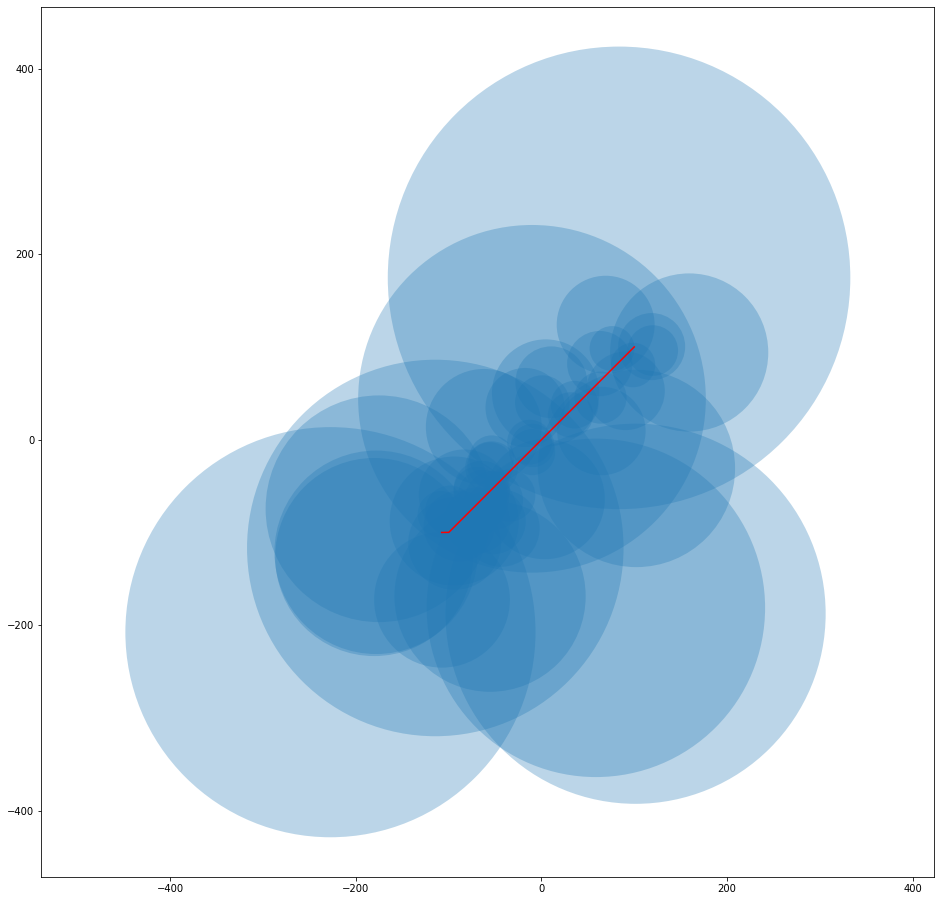

In [69]:

fig, ax = plt.subplots(figsize=(16, 16),)

ax.plot(trj_x, trj_y, 'r')
circles = [plt.Circle((in_field_subset_x[i],in_field_subset_y[i]), radius=in_field_subset_w[i]/2.) 
           for i in range(in_field_subset_x.shape[0])]
cc = mpl.collections.PatchCollection(circles, alpha=0.3)
ax.add_collection(cc)

ax.set_xlim(-200, 200)
ax.axis("equal")
plt.show()

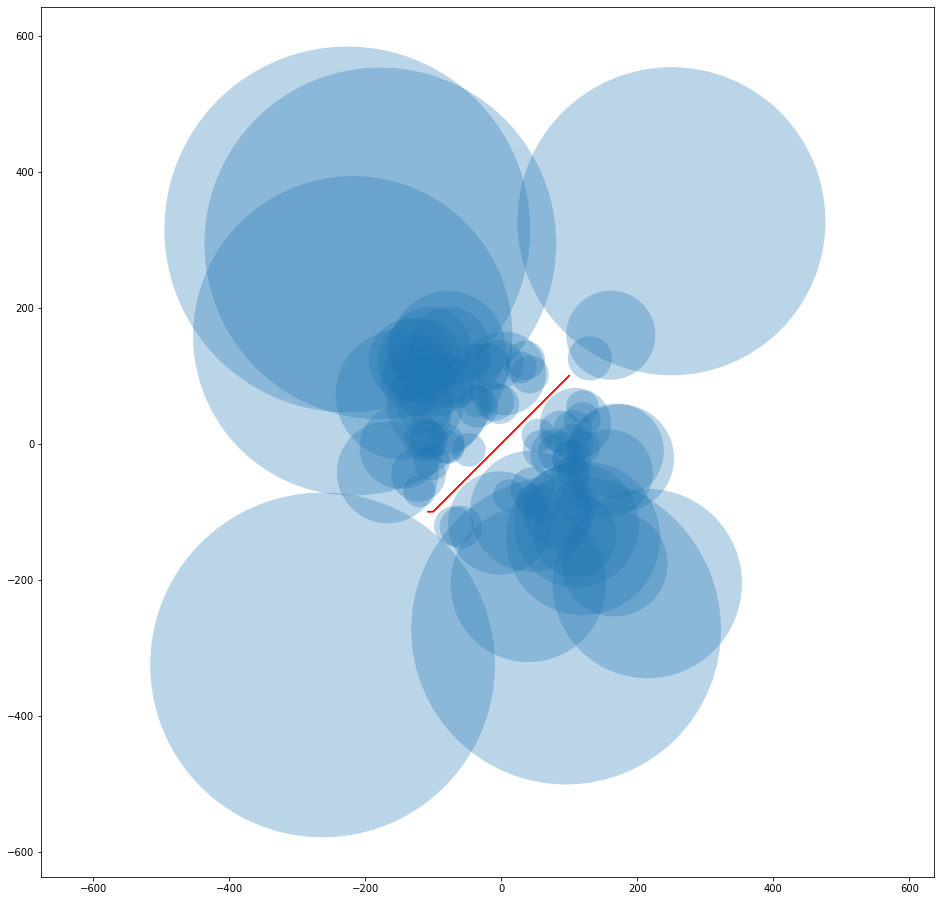

In [70]:
fig, ax = plt.subplots(figsize=(16, 16),)
ax.plot(trj_x, trj_y, 'r')
sct = ax.scatter(out_field_subset_x, out_field_subset_y, s=0, alpha=0.3, clip_on=False)

ax.plot(trj_x, trj_y, 'r')
circles = [plt.Circle((out_field_subset_x[i],out_field_subset_y[i]), radius=out_field_subset_w[i]/2.) 
           for i in range(out_field_subset_x.shape[0])]
c = mpl.collections.PatchCollection(circles, alpha=0.3)
ax.add_collection(c)

ax.axis("equal")
plt.show()

In [71]:
population = 'GC'
nbins = 10
bin_sample_size = 5

in_field_keys = []
in_field_xs = []
in_field_ys = []
in_field_ws = []
for key in in_field[population]:
    item = input_features[population][key]
    x_offsets = item['X Offset']
    y_offsets = item['Y Offset']
    widths = item['Field Width']
    for i in range(len(x_offsets)):
        x = x_offsets[i]
        y = y_offsets[i]
        w = widths[i]
        in_field_keys.append(key)
        in_field_xs.append(x)
        in_field_ys.append(y)
        in_field_ws.append(w)

in_field_inds = np.asarray(in_field_keys)
in_field_x = np.asarray(in_field_xs)
in_field_y = np.asarray(in_field_ys)
in_field_w = np.asarray(in_field_ws)

selection_bins = np.linspace(40, 800, nbins)
in_field_w_inds = np.digitize(in_field_w, selection_bins)
in_field_selection_bins = []
for i in range(nbins-1):
    candidates = in_field_inds[np.where(in_field_w_inds == i)]
    if len(candidates) > 0:
        selection = np.random.choice(candidates, bin_sample_size)
        in_field_selection_bins.append(selection)
    else:
        in_field_selection_bins.append(np.asarray([]))


In [72]:
population = 'GC'
nbins = 10
bin_sample_size = 5

out_field_keys = []
out_field_xs = []
out_field_ys = []
out_field_ws = []
for key in out_field[population]:
    item = input_features[population][key]
    x_offsets = item['X Offset']
    y_offsets = item['Y Offset']
    widths = item['Field Width']
    for i in range(len(x_offsets)):
        x = x_offsets[i]
        y = y_offsets[i]
        w = widths[i]
        out_field_keys.append(key)
        out_field_xs.append(x)
        out_field_ys.append(y)
        out_field_ws.append(w)

out_field_inds = np.asarray(out_field_keys)
out_field_x = np.asarray(out_field_xs)
out_field_y = np.asarray(out_field_ys)
out_field_w = np.asarray(out_field_ws)

selection_bins = np.linspace(40, 800, nbins)
out_field_w_inds = np.digitize(out_field_w, selection_bins)
out_field_selection_bins = []
out_field_selection_w = []
out_field_selection_x = []
out_field_selection_y = []
for i in range(nbins-1):
    candidates = out_field_inds[np.where(out_field_w_inds == i)]
    if len(candidates) > 0:
        selection = np.random.choice(candidates, bin_sample_size)
        out_field_selection_bins.append(selection)
    else:
        out_field_selection_bins.append(np.asarray([]))


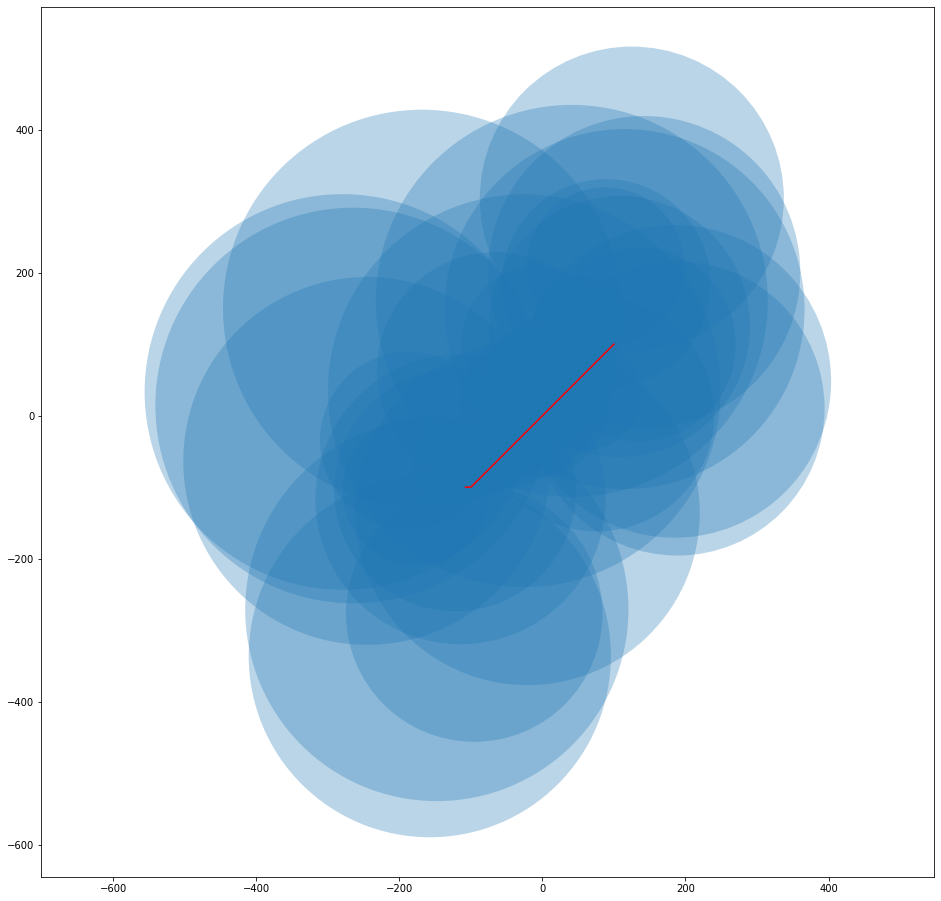

In [73]:
fig, ax = plt.subplots(figsize=(16, 16),)

ax.plot(trj_x, trj_y, 'r')
circles = []

for sbin in in_field_selection_bins:
    for s in sbin:
        w = input_features[population][s]['Field Width']
        x = input_features[population][s]['X Offset']
        y = input_features[population][s]['Y Offset']
        for i in range(len(x)):
            circles.append(plt.Circle((x[i],y[i]), radius=w[i]/2.))

cc = mpl.collections.PatchCollection(circles, alpha=0.3)
ax.add_collection(cc)

ax.set_xlim(-200, 200)
ax.axis("equal")
plt.show()

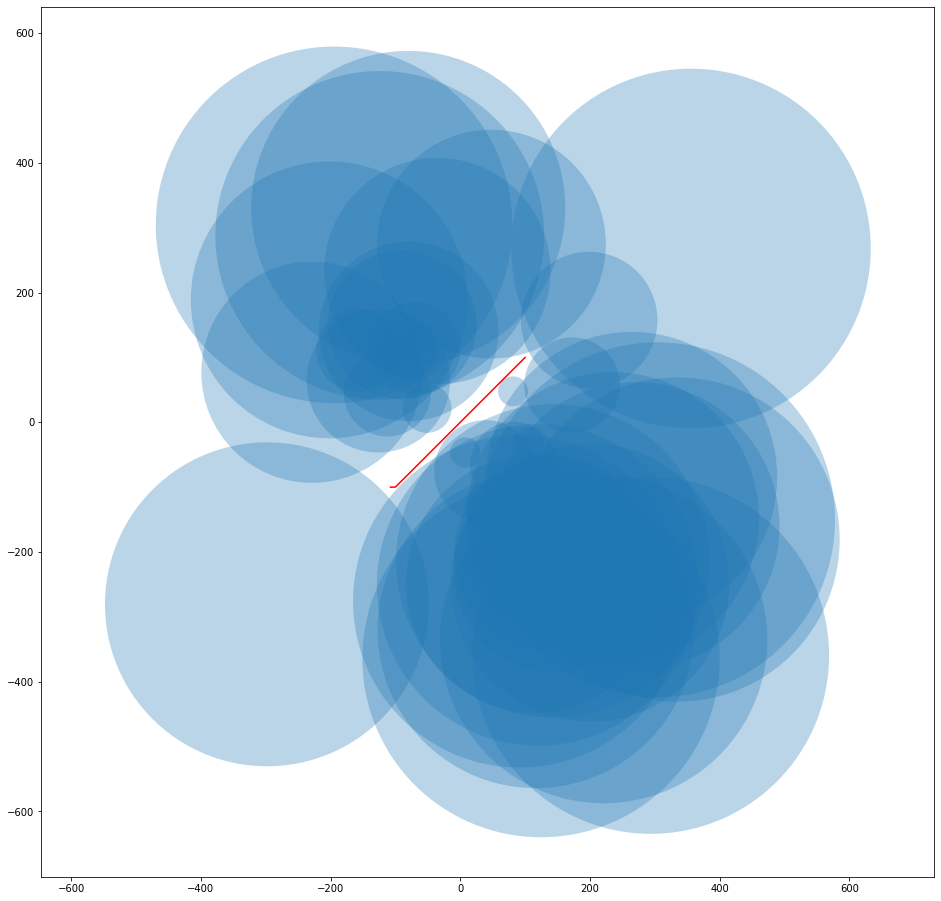

In [74]:
fig, ax = plt.subplots(figsize=(16, 16),)

ax.plot(trj_x, trj_y, 'r')
circles = []

for sbin in out_field_selection_bins:
    for s in sbin:
        w = input_features[population][s]['Field Width']
        x = input_features[population][s]['X Offset']
        y = input_features[population][s]['Y Offset']
        for i in range(len(x)):
            circles.append(plt.Circle((x[i],y[i]), radius=w[i]/2.))

cc = mpl.collections.PatchCollection(circles, alpha=0.3)
ax.add_collection(cc)

ax.set_xlim(-200, 200)
ax.axis("equal")
plt.show()

In [ ]:
populations = ['GC', 'LPP']
PF_arena_dicts = defaultdict(lambda: defaultdict(lambda: None))
this_spike_namespace = '%s %s %s' % (spike_events_namespace_id, arena_id, trajectory_id)
this_spike_namespace = spike_namespace_id
print('reading %s' % spike_input_path)
spkdata = spikedata.read_spike_events(spike_input_path, populations, this_spike_namespace,
                                          spike_train_attr_name='t', time_range=[500., 9500.])

spkpoplst = spkdata['spkpoplst']
spkindlst = spkdata['spkindlst']
spktlst = spkdata['spktlst']
num_cell_spks = spkdata['num_cell_spks']
pop_active_cells = spkdata['pop_active_cells']
tmin = spkdata['tmin']
tmax = spkdata['tmax']

time_range = [tmin, tmax]
time_bins  = np.arange(time_range[0], time_range[1], bin_size)

for i, subset in enumerate(spkpoplst):

    spkts         = spktlst[i]
    spkinds       = spkindlst[i]
    spkdict       = spikedata.make_spike_dict(spkinds, spkts)

    rate_bin_dict = spikedata.spike_density_estimate(subset, spkdict, time_bins, arena_id=arena_id,
                                                             trajectory_id=trajectory_id, progress=True, **baks_config())
    PF_dict = spikedata.place_fields(subset,  65., rate_bin_dict, trajectory, arena_id=arena_id,
                                         trajectory_id=trajectory_id, progress=True, **pf_config())
        
    PF_arena_dicts[arena_id][subset] = PF_dict

In [ ]:
LPP_pf_dists = []
LPP_pf_dict = PF_arena_dicts[arena_id]['LPP']
for gid in LPP_pf_intersection:
    reference_x = LPP_input_features[gid]['X Offset']
    reference_y = LPP_input_features[gid]['Y Offset']
    result_x = LPP_pf_dict[gid]['pf_x_locs']
    result_y = LPP_pf_dict[gid]['pf_y_locs']
    reference_locs = np.column_stack((reference_x, reference_y))
    result_locs = np.column_stack((result_x, result_y))
    LPP_pf_dists.append(pf_dist(reference_locs, result_locs))
LPP_pf_dists_array = np.asarray(sorted(LPP_pf_dists))


In [ ]:
print(np.min(LPP_pf_dists_array), np.max(LPP_pf_dists_array), np.mean(LPP_pf_dists_array))
plt.plot(LPP_pf_dists_array)

In [ ]:
GC_input_features_keys = set([ k for k in GC_input_features.keys() if len(GC_input_features[k]['X Offset']) > 0])
print(len(GC_input_features_keys))
GC_pf_keys = set([ k for k in PF_arena_dicts[arena_id]['GC'].keys() if len(PF_arena_dicts[arena_id]['GC'][k]['pf_x_locs']) > 0])
print(len(GC_pf_keys))

In [ ]:
GC_pf_intersection = GC_input_features_keys.intersection(GC_pf_keys)
print(len(GC_pf_intersection))

In [ ]:
GC_pf_dists = []
GC_pf_dict = PF_arena_dicts[arena_id]['GC']
for gid in GC_pf_intersection:
    reference_x = GC_input_features[gid]['X Offset']
    reference_y = GC_input_features[gid]['Y Offset']
    result_x = GC_pf_dict[gid]['pf_x_locs']
    result_y = GC_pf_dict[gid]['pf_y_locs']
    reference_locs = np.column_stack((reference_x, reference_y))
    result_locs = np.column_stack((result_x, result_y))
    GC_pf_dists.append(pf_dist(reference_locs, result_locs))
GC_pf_dists_array = np.asarray(sorted(GC_pf_dists))


In [ ]:
print(np.min(GC_pf_dists_array), np.max(GC_pf_dists_array), np.mean(GC_pf_dists_array))
plt.plot(GC_pf_dists_array)